# 仕訳データの異常度分析

近年Continuous Auditingといって、会計処理が行われるごとに怪しい仕訳でないかをチェックしていくことで期末監査の負担を減らそうという試みがあります。

この「怪しい仕訳でないか」を機械学習による異常検知が応用でき、監査法人を中心に開発が進められています。

EY
https://www.eyjapan.jp/library/issue/info-sensor/2019-03-04.html

PwC
https://www.pwc.com/jp/ja/press-room/halo-for-journals180416.html

なお、EYは2018年6月に仕訳の異常検知を応用した特許（特許第6345856号）を取得していますので、興味がある方は読んでみてください（どちらかというとContinuous Auditingというより監査自動化の内容です）。

会計仕訳の異常検知がどんな感じになるのかを試してみました。

※数学的にいい加減な文章のため、6. Refferencesに紹介する文献で正確な知識を得てください。

### 0. セットアップ

1. matplotlibに日本語のフォントを追加、設定します。

2. 今回は有限会社アイソフトの製品「税理士いらず」のサンプルデータ「株式会社サンプルデザイン」をお借りします。以下のサイトから仕訳データをダウンロードし、好きな場所に置きます（以下ではこのスクリプトファイルと同じディレクトリに"testdata.csv"の名称で置いてあることを想定してます）。

http://www.z-irazu.jp/sample.html

### 1. データの読み込み

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
filename='./testdata.csv'
JE_raw=pd.read_csv(filename, \
                   header=None,index_col=False, engine="python", encoding="SHIFT-JIS",\
                   names=['date','debit_account_name','debit_amount','debit_tax','credit_account_name','credit_amount','credit_tax','description_1','description_2'])

最終行（index:551）に怪しい仕訳を挿入しておきます。

なお、この仕訳は「出資金」勘定残高を著しく増加させるため、期末残高を期首時点の残高と比較することでも、怪しい会計処理であることはわかります。
しかしながら、期末残高の確定を待たずに監査をしていくContinuous Auditingではこのような手法が使えません。

In [3]:
JE_raw.loc[JE_raw.shape[0],:]=['2019/3/30','出資金',5653800,'課税(8%)','外注加工費',5653800,np.nan,'株式会社不正改竄最高','翌期に減損すればいいじゃん']
print(JE_raw.shape)
JE_raw.tail()

(552, 9)


,date,debit_account_name,debit_amount,debit_tax,credit_account_name,credit_amount,credit_tax,description_1,description_2
547,2019/ 3/30,外注加工費,1728000.0,課税(8%),未払金,1728000.0,NaN,有限会社吉本デザイン,３１年３月末請求受理分の未払計上
548,2019/ 3/30,未払金,2483352.0,NaN,普通預金,2483352.0,NaN,有限会社吉本デザイン,３１年２月末請求受理分の支払
549,2019/ 3/30,未払金,648.0,NaN,支払手数料,648.0,課税(8%),有限会社吉本デザイン,３１年２月末請求受理分の支払（振込手数料分）
550,2019/ 3/30,給料手当,191600.0,NaN,未払費用,191600.0,NaN,鈴木淑子,給料（３１年３月手取り支給分の未払計上）
551,2019/3/30,出資金,5653800.0,課税(8%),外注加工費,5653800.0,NaN,株式会社不正改竄最高,翌期に減損すればいいじゃん


### 2. ベクトルデータへ変換

In [4]:
def ConvertToJEvector(JE_raw):
    Names=np.concatenate([JE_raw.loc[:,'debit_account_name'].values,JE_raw.loc[:,'credit_account_name'].values])
    TBindex=np.unique(Names)
    JE_vec=pd.DataFrame(np.zeros((TBindex.shape[0],JE_raw.shape[0])),dtype=int)
    JE_vec.index=TBindex
    for itr in range(JE_raw.shape[0]):
        rcd=JE_raw.iloc[itr,:]
        mask_d=rcd["debit_account_name"] == TBindex
        mask_c=rcd["credit_account_name"] == TBindex
        JE_vec.iloc[mask_d,itr]=rcd['debit_amount']
        JE_vec.iloc[mask_c,itr]=rcd['credit_amount']*(-1)
    return JE_vec
        
JE_vec=ConvertToJEvector(JE_raw)

### 3. 仕訳ベクトルデータの概観


会社のある活動に対して仕訳のパターンはだいたい決まっており、仕訳データはそのパターンがいくつか集まってできています。

例えば、以下の(a)の仕訳が年に9回、(b)の仕訳が年に12回のようになっています。

(a) 売掛金 200 / 売上 200

(b) 仕入 100 / 買掛金 100

したがって、仕訳データの分析では、似ている仕訳同士はすごく似ていますが（全く同一の場合も多い）、似ていない仕訳同士は全く似ていません。

このような関係はt-SNE[1]という次元削減方法によって2次元にプロットできます。t-SNEはデータの近傍の関係を保存するように次元を落とします。

（今回使用したデータは借方と貸方の勘定科目が1ずつの1行仕訳なので、仕訳ベクトルは非ゼロ要素を2つしかもちません。したがって、相関係数によって勘定科目が全く同一な仕訳を綺麗にクラスタリングでき、勘定科目の組み合わせがレアな仕訳は簡単に炙り出せます。しかし、実際に会社で使用される仕訳データは複数行で一つの取引に対応したり、多くの勘定科目が動く取引があるため、今回このような方法は使用していません。）

In [5]:
from sklearn.manifold import TSNE
JE_vec_red = TSNE(n_components=2, random_state=0,perplexity=30).fit_transform(JE_vec.transpose())

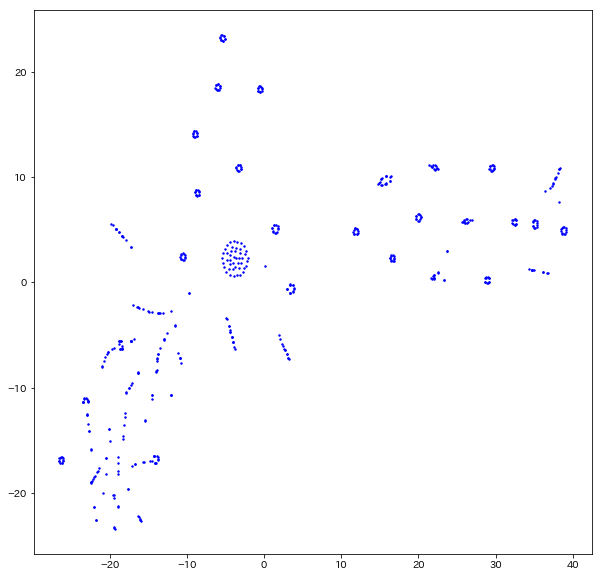

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(JE_vec_red[:,0],JE_vec_red[:,1],s=2,c='b', cmap='jet')

このように、凝集したクラスターがたくさんあります。
なお、t-SNEではクラスター間の関係は元データにおける関係をほとんど保存していないため、クラスター間の距離にはほとんど意味がありません。

### 4. 仕訳の異常分析

#### 4.1 データ点の異常検知手法について
異常検知にはいろいろ種類がありますが、特徴抽出をしてもしなくても、最終的にはデータ点について異常度を算出することになります。
データ点の異常度の算定方法は主に下のパターンに分類されます。個人的な使い分けをメモってます。正確な知識は[2]を参照ください。
- 近傍にデータ点があるかに基づく方法
 - k-Nearest Neighbor (k-NN):周辺のデータに基づく方法、データの集まり具合の評価が画一的な場合）
 - Local Outlier Factor (LOF):（周辺のデータに基づく方法、データの集まり具合の評価が周辺のデータに依存する場合）
- 分布を当てはめる方法
 - 正規分布（ホテリング統計量）:クラスターが一つ（分布の山が1つの場合に有効、またはクラスタリングにより1つの山の分布に分けられる場合に有効）
 - 混合正規分布（ホテリング統計量）:クラスターが複数で個数を知っている場合に有効
- 分布をデータから補間してつくる方法
 - Kearnel Dencity Estimation：クラスター数がわからない、クラスターにさえなっていない複雑な分布
- 分類機を用いる方法
 - One Class SVM:複雑な分布だがある特徴空間で疎な境界で分けられる場合
 - VAEなどの深層学習を用いて分類学習

ちなみにEYの特許では最終段階で異常検知を行いますが、原文でk-NN、LOF、分布が1つの場合のホテリング統計量の3つの手法について言及しています。


#### 4.2 どの方法を使うか
異常を定義を「よく似た仕訳がない」とするならば、異常な仕訳データ点を周辺にデータ点が存在しない点と決めると良さそうです。

そこで、周辺のデータ点の集まり具合をk-NNで評価します。

距離は元データのユークリット距離を使います。なお、仕訳ベクトルは基本的にスパースになるので、高次元でもユークリッド距離が使えます。
スパースではない場合は、t-SNEの平面上の距離が有効かもしれません。また、k(近傍点の個数)ですが、今回は「類似の仕訳が1つあるか」で異常を判定するため1にしています。毎月切られる仕訳を対象とする場合は他に「11個似た仕訳があるか」で異常を判定するためにk=11とすることも考えられます。

In [7]:
from sklearn.neighbors import NearestNeighbors
k=1
nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(JE_vec.transpose()) # k+1 としているのは自分自身が0番目にくるため。
distances, indices = nbrs.kneighbors(JE_vec.transpose())

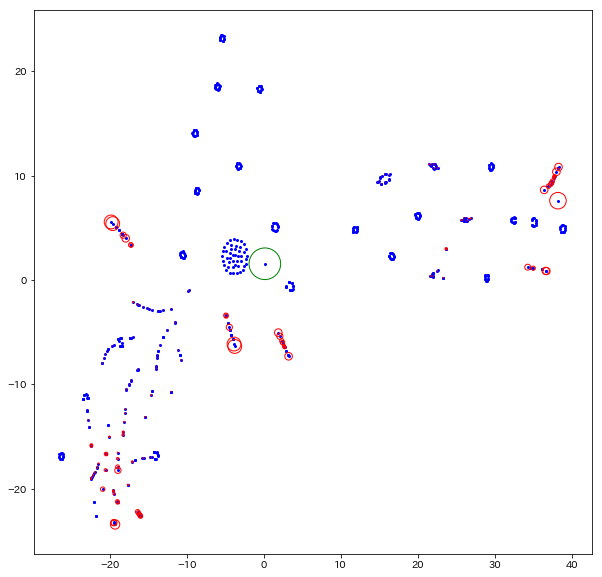

In [8]:
scores=distances[:,k]
scores_minmax = (scores-scores.min()) / (scores.max() - scores.min())

plt.figure(figsize=(10,10))

plt.scatter(JE_vec_red[:,0],JE_vec_red[:,1],c='b',s=4, cmap='jet')

plt.scatter(JE_vec_red[:-1,0],JE_vec_red[:-1,1], edgecolors='r',s=scores_minmax*1000,
            facecolors='none', label='Outlier scores')
plt.scatter(JE_vec_red[-1,0],JE_vec_red[-1,1], edgecolors='g',s=scores_minmax[-1]*1000,
            facecolors='none', label='Outlier scores')


青のデータ点の周囲の赤い円の半径がk-NNによる異常度を表しています。一番下の行にわざと挿入した怪しい仕訳は円を緑にしています。

怪しい仕訳の異常度が高くなっており、うまく検出できていることがわかります。

また、この方法なら、仕訳データが入力されるごとにk-NN法で異常度を計算でき、Continuous Auditingができますね。

### 5. 教師ありの異常検知

もう1つ紹介します。2018/4/1から2018/12/31までの仕訳は全て検証済みであり、期末に2019/1/1から2019/3/31までの仕訳の異常検知を行うことを考えます。
仕訳データ点の分布を前期比較で行いたい場合には同様のアプローチが適用可能です。


読み込んだデータの日付が文字列なのでdatetime型に変換し、2018/4/1から2018/12/31までのデータと2019/1/1から2019/3/31までのデータに分割します。

In [9]:
def fnc_date_formatted(x):
    x_date_format=datetime.datetime.strptime(x.replace(" ",""), "%Y/%m/%d")
    return x_date_format

date_formatted=JE_raw['date'].map(fnc_date_formatted)
JE_raw['date_formatted']=date_formatted

In [10]:
import workdays
from dateutil.relativedelta import relativedelta
start_date = datetime.datetime(2018,4,1)
end_date = datetime.datetime(2019,3,31)

m=0
M_start_date=start_date+relativedelta(months=m)
M_end_date=M_start_date+relativedelta(months=9)
mask=(JE_raw.loc[:,'date_formatted'] >= M_start_date) & (JE_raw.loc[:,'date_formatted'] < M_end_date)

JE_vec_red_train=JE_vec_red[mask,:]

m=9
M_start_date=start_date+relativedelta(months=m)
M_end_date=M_start_date+relativedelta(months=3)
mask=(JE_raw.loc[:,'date_formatted'] >= M_start_date) & (JE_raw.loc[:,'date_formatted'] < M_end_date)
    
JE_raw_4Q=pd.DataFrame(JE_raw.loc[mask,:])
JE_vec_red_4Q=JE_vec_red[mask,:]


ここで、上の図のような点の配置を2018/4/1から2018/12/31までの教師データで作成し、2019/1/1から2019/3/31の検証データが教師データの近くにあるかで評価します。
先ほどのようにk-NNでやっても良いのですが、せっかくなので別の方法を試してみます。

教師データのヒストグラムを作成し、検証データが度数が高いところにあるかを測定します（低ければ異常と判定します）。ここで、ヒストグラムはがたがたしており離散的で検証データの位置が少しずれただけで異常度が跳ね上がる点（不連続な箇所）ができてしまいます。そこで、滑らかな分布にするためにカーネル密度推定を用います。

ヒートマップの可視化のためにグリッドを作成します。

In [11]:
from sklearn.neighbors import KernelDensity
xmin = JE_vec_red[:,0].min()
xmax = JE_vec_red[:,0].max()
ymin = JE_vec_red[:,1].min()
ymax = JE_vec_red[:,1].max()
X,Y= np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
grid=np.concatenate([np.reshape(X,[10000,1]),np.reshape(Y,[10000,1])],axis=1)

パラメータ:bwは大きいほど推定分布が大雑把になり、0に近いほど細かくなります。0に近づけるとデルタ関数のあつまりのようになります。今回は1くらいにしてクラスターが繋がらないようにします。

In [12]:
bw=1
score_self=np.zeros((JE_raw.shape[0],2))
kde_train = KernelDensity(bandwidth=bw, metric='euclidean',
                        kernel='gaussian', algorithm='ball_tree').fit(JE_vec_red_train)
score_all = np.exp(kde_train.score_samples(grid))

score_test = -1*kde_train.score_samples(JE_vec_red_4Q)

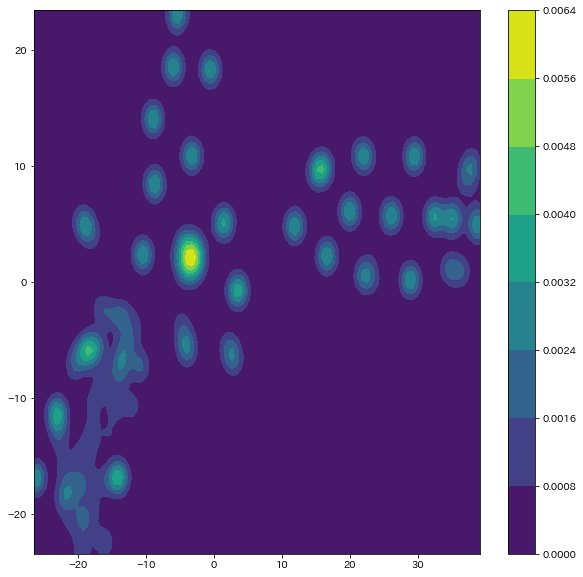

In [13]:
plt.figure(figsize=(10,10))
plt.contourf(X,Y,score_all.reshape(100,100))
plt.colorbar()

In [14]:
JE_raw_4Q.loc[:,'Change']=score_test

In [15]:
JE_raw_4Q.sort_values(by='Change',ascending=False).head(40)

,date,debit_account_name,debit_amount,debit_tax,credit_account_name,credit_amount,credit_tax,description_1,description_2,date_formatted,Change
551,2019/3/30,出資金,5653800.0,課税(8%),外注加工費,5653800.0,NaN,株式会社不正改竄最高,翌期に減損すればいいじゃん,2019-03-30,9.226500
484,2019/ 2/20,普通預金,367.0,NaN,受取利息,367.0,非課税,預金利息,NaN,2019-02-20,7.841896
465,2019/ 1/31,支払利息,75000.0,非課税,普通預金,75000.0,NaN,丹沢銀行／厚木支店,NaN,2019-01-31,7.677772
427,2019/ 1/10,源泉税等預り金,141060.0,NaN,現金,141060.0,NaN,鈴木一郎,源泉税納付（３０年７月分から１２月分まで）,2019-01-10,7.394468
429,2019/ 1/10,源泉税等預り金,50400.0,NaN,現金,50400.0,NaN,鈴木淑子,源泉税納付（３０年７月分から１２月分まで）,2019-01-10,7.228974
437,2019/ 1/15,普通預金,971352.0,NaN,売掛金,971352.0,NaN,横浜デザイン株式会社,３０年１１月末請求分の売掛回収,2019-01-15,7.129867
434,2019/ 1/10,源泉税等預り金,7620.0,NaN,現金,7620.0,NaN,田中信夫,源泉税納付（３０年７月分から１２月分まで）,2019-01-10,7.109937
523,2019/ 3/12,旅費交通費,4560.0,課税(8%),現金,4560.0,NaN,タクシー代,NaN,2019-03-12,6.866179
486,2019/ 2/22,新聞図書費,32600.0,課税(8%),現金,32600.0,NaN,書籍代,NaN,2019-02-22,6.771379
482,2019/ 2/15,消耗品費,9720.0,課税(8%),現金,9720.0,NaN,名刺代,NaN,2019-02-15,6.710949


今回は仕訳データのみから異常検知を試みました。仕訳データのみから異常検知する場合、「過去に似た仕訳があるか」を異常としています。

その他いくつか方法が考えられます。もっとも重要なのは、具体的に何を"異常"とするかです。（数学的に扱うには"異常"を具体的にしなければなりません。）

- 摘要欄のテキストのOne hot encodingベクトルの距離を用いる方法（手法は今回のと同様）:「摘要欄のテキストにレアな語句が含まれていること」を異常とする。
- 仕訳が切られた時点のストックのデータ、外部環境のデータなどのデータの特徴から仕訳の起こりやすさを学習する方法（VAEなど）:「経済合理性のない」を異常とする。
- 仕訳の入力時点の間隔データを用いる方法（点過程、生存時間分析など）：「定常的でないタイミング」を異常とする。

### 6. おまけ

LOFも試してみたのですが、近傍点の個数を3以下にすると怪しい仕訳を検出できなくなります。これは、怪しい仕訳の左上にばらつきの大きい仕訳データ点の集団があるからでしょう（LOFでは近傍の点のばらつきで距離が修正されています）。

In [16]:
from sklearn.neighbors import LocalOutlierFactor

LOF = LocalOutlierFactor(n_neighbors=3,contamination=0.1)
LOF.fit_predict(JE_vec.transpose())
scores=LOF.negative_outlier_factor_
scores_minmax = (scores.max() - scores) / (scores.max() - scores.min())

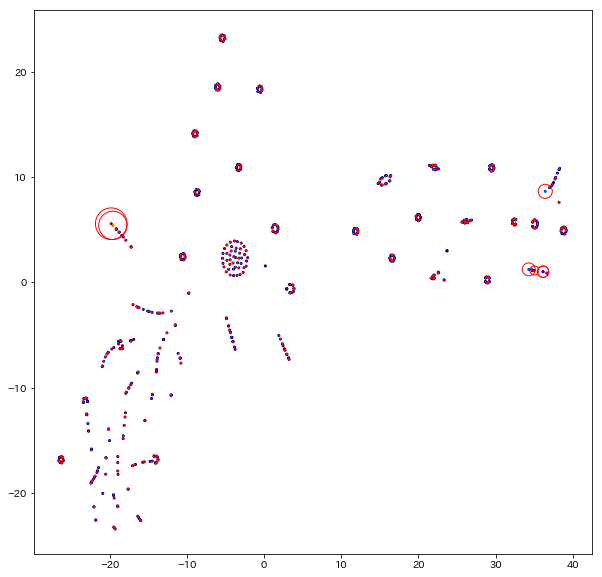

In [17]:
plt.figure(figsize=(10,10))

plt.scatter(JE_vec_red[:,0],JE_vec_red[:,1],c=scores_minmax,s=4, cmap='jet')

plt.scatter(JE_vec_red[:-1,0],JE_vec_red[:-1,1], edgecolors='r',s=scores_minmax*1000,
            facecolors='none', label='Outlier scores')
plt.scatter(JE_vec_red[-1,0],JE_vec_red[-1,1], edgecolors='g',s=scores_minmax[-1]*1000,
            facecolors='none', label='Outlier scores')


### 7. References

[1] Laurens van der Maaten and Geoffrey Hinton. Visualizing data using t-sne. Journal of machine
learning research, 9(Nov):2579–2605, 2008.

参考 https://www.youtube.com/watch?v=EMD106bB2vY

[2] 井出 剛 「入門 機械学習による異常検知―Rによる実践ガイド」
